In [4]:
from spreg import OLS, vif, OLS_Regimes
import pysal as ps
import libpysal
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from tobler.area_weighted import area_join, area_interpolate
from pysal.explore import esda
import contextily

In [2]:
# Load regression gds 
selected = gpd.read_file('../YouthInTheCity/data/regression_gdf.shp')


# Select features manually
selected.drop(columns=['HK_EU15', 'HK_EU28', 'HK_Polen', 'HK_EheJug', 'HK_EheSU', 'HK_Turk',
              'schools', 'universiti','kindergart','HK_Arab', 'HK_Sonst', 'HK_NZOrd', 'BZR_NAME', 
              'noise',  'health_car', 'vegpm10', 'change','ch_rate',
            'public_tra', 'green' ,'other_sch', 'vocat_sch', 'Gymnasium',
                'sp_nee_sch','eating', 'community','night_life', 'water',  
              'public_ser','dyn_ew', 'dyn_unempl', 'priv_schoo', 'primary_sc',
            'education', 'secon_sch', 'five_y_pls', 'dyn_sales','air', 'bio'], inplace=True)



In [3]:
selected.columns

Index(['PLR_ID', 'culture', 'outdoor_fa', 'outdoor_le', 'mig_rate', 'ave_rent',
       'social_hou', 'public_hou', 'child_pov', 'vegpm20', 'kita', 'stations',
       'geometry'],
      dtype='object')

In [5]:
# downscaling 
blocks = gpd.read_file('../raw_data/maps/blocks.shp')
blocks.to_crs(crs='EPSG:25833', inplace=True)

In [6]:
interpolate = area_interpolate(
    source_df= selected,
    target_df= blocks,
    intensive_variables=['mig_rate', 'ave_rent','culture', 'outdoor_fa', 'outdoor_le','kita', 'stations',
       'social_hou', 'public_hou', 'child_pov', 'vegpm20']
)

In [7]:
# Export it as shapefile
interpolate.to_file('../raw_data/blocks_data.shp')

# Load it again
selected = gpd.read_file('../raw_data/blocks_data.shp')

In [13]:
#selected.to_csv('../raw_data/reduced_df.csv')

In [13]:
#selected = pd.concat([selected, transformed_b_age], ignore_index=False, sort=False, axis=1)

In [8]:
db = libpysal.io.open('../raw_data/reduced_df.csv','r')

In [9]:
inv_dist = libpysal.weights.DistanceBand.from_dataframe(selected, 5000, geom_col='geometry', binary=False)

In [15]:
queen = libpysal.weights.Queen.from_dataframe(selected)

In [16]:
#queen.weights

In [10]:
corr = selected.corr()
corr_df = corr.unstack().reset_index() #Unstack correlation matrix
corr_df.columns = ["feature_1", "feature_2", "correlation"] #Rename the columns
corr_df.sort_values(by="correlation", ascending=False, inplace=True)
corr_df = corr_df[corr_df["feature_1"] != corr_df["feature_2"]] #remove the self-corr
corr_df.head(20)

,feature_1,feature_2,correlation
9,mig_rate,child_pov,0.667716
99,child_pov,mig_rate,0.667716
57,kita,culture,0.586418
27,culture,kita,0.586418
25,culture,outdoor_fa,0.559130
35,outdoor_fa,culture,0.559130
5,mig_rate,kita,0.508538
55,kita,mig_rate,0.508538
13,ave_rent,culture,0.502103
23,culture,ave_rent,0.502103


In [12]:
y = np.array(selected['child_pov'])
X = selected.drop(columns=['child_pov', 'geometry']).to_numpy()

In [13]:
selected.columns

Index(['mig_rate', 'ave_rent', 'culture', 'outdoor_fa', 'outdoor_le', 'kita',
       'stations', 'social_hou', 'public_hou', 'child_pov', 'vegpm20',
       'geometry'],
      dtype='object')

In [14]:
columns = [
'culture', 'outdoor_fa', 'outdoor_le', 'mig_rate', 'ave_rent',
       'social_hou', 'public_hou', 'vegpm20', 'kita',
       'stations'
]

In [16]:
basic_ols = OLS(y,
                X,
                w=inv_dist,
                name_y='child_pov',
                name_x=columns,
                name_w='dist',
                name_ds='basic_model',
                white_test=True,
                gwk=inv_dist ,
                spat_diag=True,
                moran=True)

In [23]:
#basic_ols.predy

(array([ 18.,  36.,  80., 103., 101.,  94.,  41.,  32.,  23.,   8.]),
 array([-5.20385327,  1.49291943,  8.18969213, 14.88646482, 21.58323752,
        28.28001022, 34.97678292, 41.67355562, 48.37032832, 55.06710101,
        61.76387371]),
 <BarContainer object of 10 artists>)

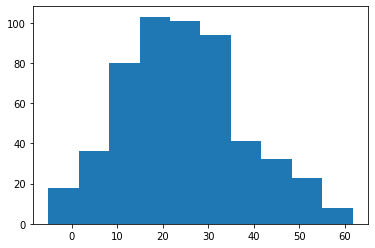

In [24]:
plt.hist(basic_ols.predy.flatten())

<AxesSubplot:>

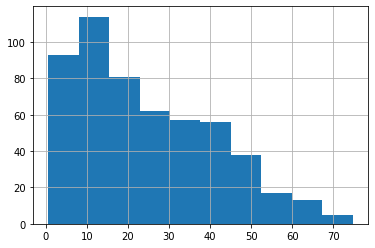

In [25]:
selected['child_pov'].hist()

In [26]:
mae(selected['child_pov'], basic_ols.predy.flatten())

7.819664494461524

In [27]:
np.sqrt(mse(selected['child_pov'], basic_ols.predy.flatten()))

9.90512403463047

In [17]:
print(basic_ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            : basic_model
Weights matrix      :        dist
Dependent Variable  :   child_pov                Number of Observations:       25352
Mean dependent var  :     17.3673                Number of Variables   :          11
S.D. dependent var  :     14.8612                Degrees of Freedom    :       25341
R-squared           :      0.6352
Adjusted R-squared  :      0.6350
Sum squared residual: 2042625.805                F-statistic           :   4411.9125
Sigma-square        :      80.606                Prob(F-statistic)     :           0
S.E. of regression  :       8.978                Log likelihood        :  -91609.590
Sigma-square ML     :      80.571                Akaike info criterion :  183241.179
S.E of regression ML:      8.9761                Schwarz criterion     :  183330.726

-----------------------------------------------------------------------------

In [30]:
v = vif(basic_ols)

In [31]:
del(v[0])

In [32]:
vif_array = np.array(v, dtype=float)

In [180]:
 vif_array[:,0]

array([2.39799134, 1.64742467, 1.21628636, 1.8895746 , 1.97571086,
       1.42645666, 1.60136667, 1.14480277, 1.22157505, 2.10162645,
       1.79417446])

In [181]:
v_d = pd.DataFrame({'feature': columns, 
                   'vif': vif_array[:,0], 
                   'tolerance':  vif_array[:,1]})

In [182]:
v_d

,feature,vif,tolerance
0,culture,2.397991,0.417016
1,outdoor_fa,1.647425,0.607008
2,outdoor_le,1.216286,0.822175
3,mig_rate,1.889575,0.529220
4,ave_rent,1.975711,0.506147
5,social_hou,1.426457,0.701038
6,public_hou,1.601367,0.624467
7,vegpm20,1.144803,0.873513
8,Gymnasium,1.221575,0.818615
9,kita,2.101626,0.475822


In [135]:
selected['preds'] = basic_ols.predy

In [136]:
selected['residuals'] = selected.child_pov - selected.preds

<AxesSubplot:>

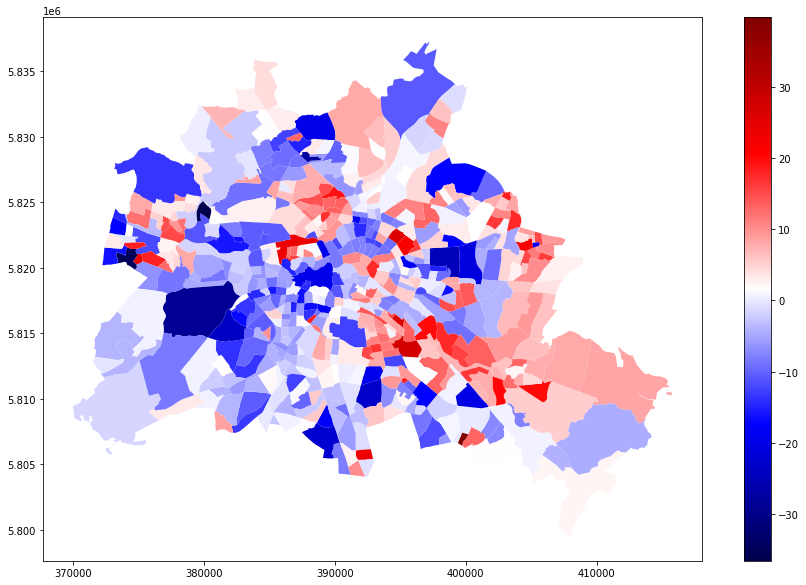

In [137]:
# plotting residuals - red = underestimation, blue = overestimation
selected.plot('residuals', figsize=(15,10), cmap= 'seismic', legend=True)

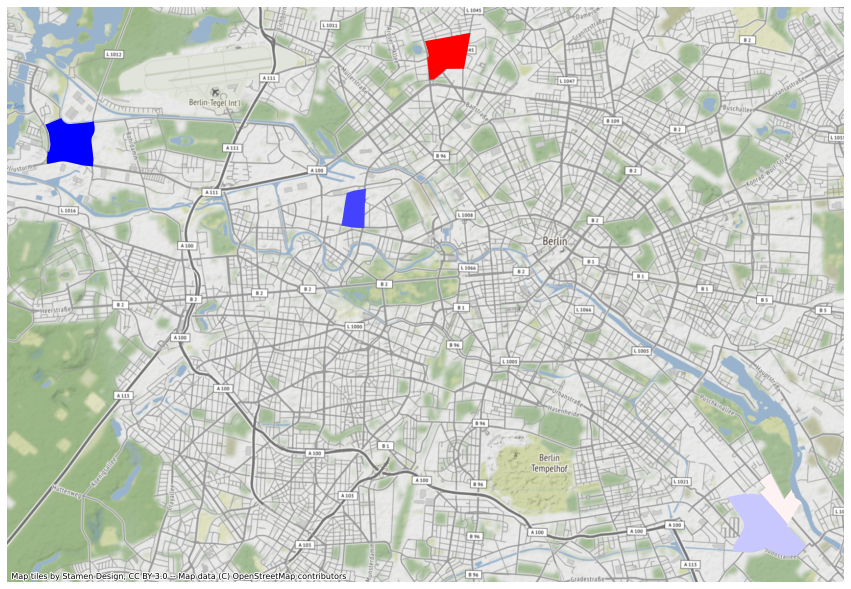

In [165]:
# instantiating knn
knn = libpysal.weights.KNN.from_dataframe(selected, k=5)
# Row standardise weights
knn.transform = "R"
# Run LISA on residuals
outliers = esda.moran.Moran_Local(basic_ols.u, knn, permutations=9999)
# Select only LISA cluster cores
error_clusters = outliers.q % 2 == 1
# Filter out non-significant clusters
error_clusters &= outliers.p_sim <= 0.001
# Add `error_clusters` and `local_I` columns
ax = (
    selected.assign(
        error_clusters=error_clusters,
        local_I=outliers.Is
        # Retain error clusters only
    )
    .query(
        "error_clusters"
        # Sort by I value to largest plot on top
    )
    .sort_values(
        "local_I"
        # Plot I values
    )
    .plot("local_I", cmap="bwr", marker=".", figsize=(15,15))
)
# Add basemap
#contextily.add_basemap(ax, crs=selected.crs)
# Remove axes
ax.set_axis_off();

In [29]:
pr2021 = gpd.read_file('../raw_data/maps/pr_2021.shp')

pr2020 = gpd.read_file('../raw_data/maps/pr_2020.shp')

In [85]:
west = gpd.read_file('../raw_data/more_maps/Ortsteile__Berlin_West_EPSG54030.shp')
east = gpd.read_file('../raw_data/more_maps/Ortsteile__Berlin_Ost_EPSG54030.shp')

east.to_crs(crs='EPSG:25833', inplace=True)

west.to_crs(crs='EPSG:25833', inplace=True)

west = west.dissolve()

east = ost.dissolve()

eastwest = ost.append(west)

eastwest['east'] = eastwest.OBJECTID.map({1:1,
                                             2:0})

/var/folders/sx/4s_zvfwj1xddph7py3s74ych0000gn/T/ipykernel_81615/174679948.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eastwest = ost.append(west)


In [61]:
eastwest = eastwest[['east','geometry']]

In [166]:
selected_east = selected.sjoin_nearest(
    eastwest, how='left').dissolve(
    by='PLR_ID')

selected = selected.merge(selected_east.reset_index()[['PLR_ID','east']], on='PLR_ID')

In [187]:
X.shape

(536, 11)

In [188]:
ols_regimes = OLS_Regimes(y,
                X,
                w=inv_dist,
                regimes=selected['east'],
                name_y='child_pov',
                name_x=columns,
                name_w='dist',
                name_ds='basic_model',
                white_test=True,
                spat_diag=True,
                moran=True)

In [190]:
print(ols_regimes.summary)

REGRESSION
----------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES ESTIMATION - REGIME 0
---------------------------------------------------------------
Data set            : basic_model
Weights matrix      :        dist
Dependent Variable  : 0_child_pov                Number of Observations:         195
Mean dependent var  :     21.2256                Number of Variables   :          12
S.D. dependent var  :     15.2800                Degrees of Freedom    :         183
R-squared           :      0.6741
Adjusted R-squared  :      0.6545
Sum squared residual:   14760.506                F-statistic           :     34.4146
Sigma-square        :      80.659                Prob(F-statistic)     :   7.068e-39
S.E. of regression  :       8.981                Log likelihood        :    -698.547
Sigma-square ML     :      75.695                Akaike info criterion :    1421.095
S.E of regression ML:      8.7003                Schwarz criterion     :    1460.371

--------------------------------

In [280]:
rook = libpysal.weights.Rook.from_dataframe(selected)

In [163]:
inv_dist = libpysal.weights.DistanceBand.from_dataframe(selected, 5000, geom_col='geometry', binary=False)



In [87]:
y_b = selected['child_pov']
X_b = selected.drop(columns=['child_pov', 'PLR_ID','geometry'])

In [88]:
### Perform permutation
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
#fit model
model = LinearRegression().fit(X_b,y_b)
#Perform permutation
permutation_score = permutation_importance(model, X_b,y_b, n_repeats=100)
#Unstack results, put in df
importance_df = pd.DataFrame(np.vstack((X_b.columns,permutation_score.importances_mean)).T)
importance_df.columns=['feature','feature importance']
#Order by importance
importance_df.sort_values(by='feature importance', ascending = False, inplace=True)
importance_df
#remove feature that have lower feature importance, run the validation score to test the reduced feature

,feature,feature importance
10,mig_rate,0.674796
17,dyn_unempl,0.201032
0,eating,0.165318
8,night_life,0.083097
11,ave_rent,0.037752
13,public_hou,0.029032
16,dyn_sales,0.024267
2,community,0.012712
5,education,0.012283
19,bio,0.011718


In [92]:
medians = selected[columns].merge(
    selected.groupby('ave_rent').residual.median().to_frame(
        'av_rent_residual'),
    how='left',
    left_on='ave_rent',
    right_index=True).sort_values('av_rent_residual').drop(columns=[
    'eating', 'culture', 'community', 'health_car', 'public_ser',
    'education', 'outdoor_fa', 'outdoor_le', 'night_life', 'water',
    'mig_rate','social_hou', 'public_hou', 'dyn_ew',
    'five_y_pls', 'dyn_sales', 'dyn_unempl', 'air', 'bio',
    'vegpm20', 'primary_sc', 'Gymnasium', 'secon_sch', 'priv_schoo', 'kita',
    'stations'
    ])

In [90]:
selected['residual'] = basic_ols.u

In [93]:
medians['ave_rent'].round().value_counts()

9.0     100
11.0     98
8.0      93
10.0     83
13.0     43
12.0     39
14.0     26
15.0     19
7.0      17
16.0     16
1.0       1
4.0       1
Name: ave_rent, dtype: int64

In [95]:
merged_medians = merged_medians.groupby('ave_rent').av_rent_residual.median().to_frame('av_rent_residual')

NameError: name 'merged_medians' is not defined

In [94]:
merged_medians['ave_rent'] = medians['ave_rent'].round()

NameError: name 'merged_medians' is not defined

<AxesSubplot:xlabel='ave_rent'>

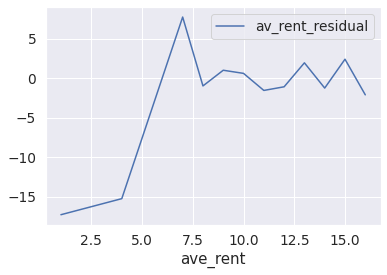

In [63]:
merged_medians.plot()

In [96]:
clusters = list(np.append(importance_df.head(8).feature.values, ('child_pov')))

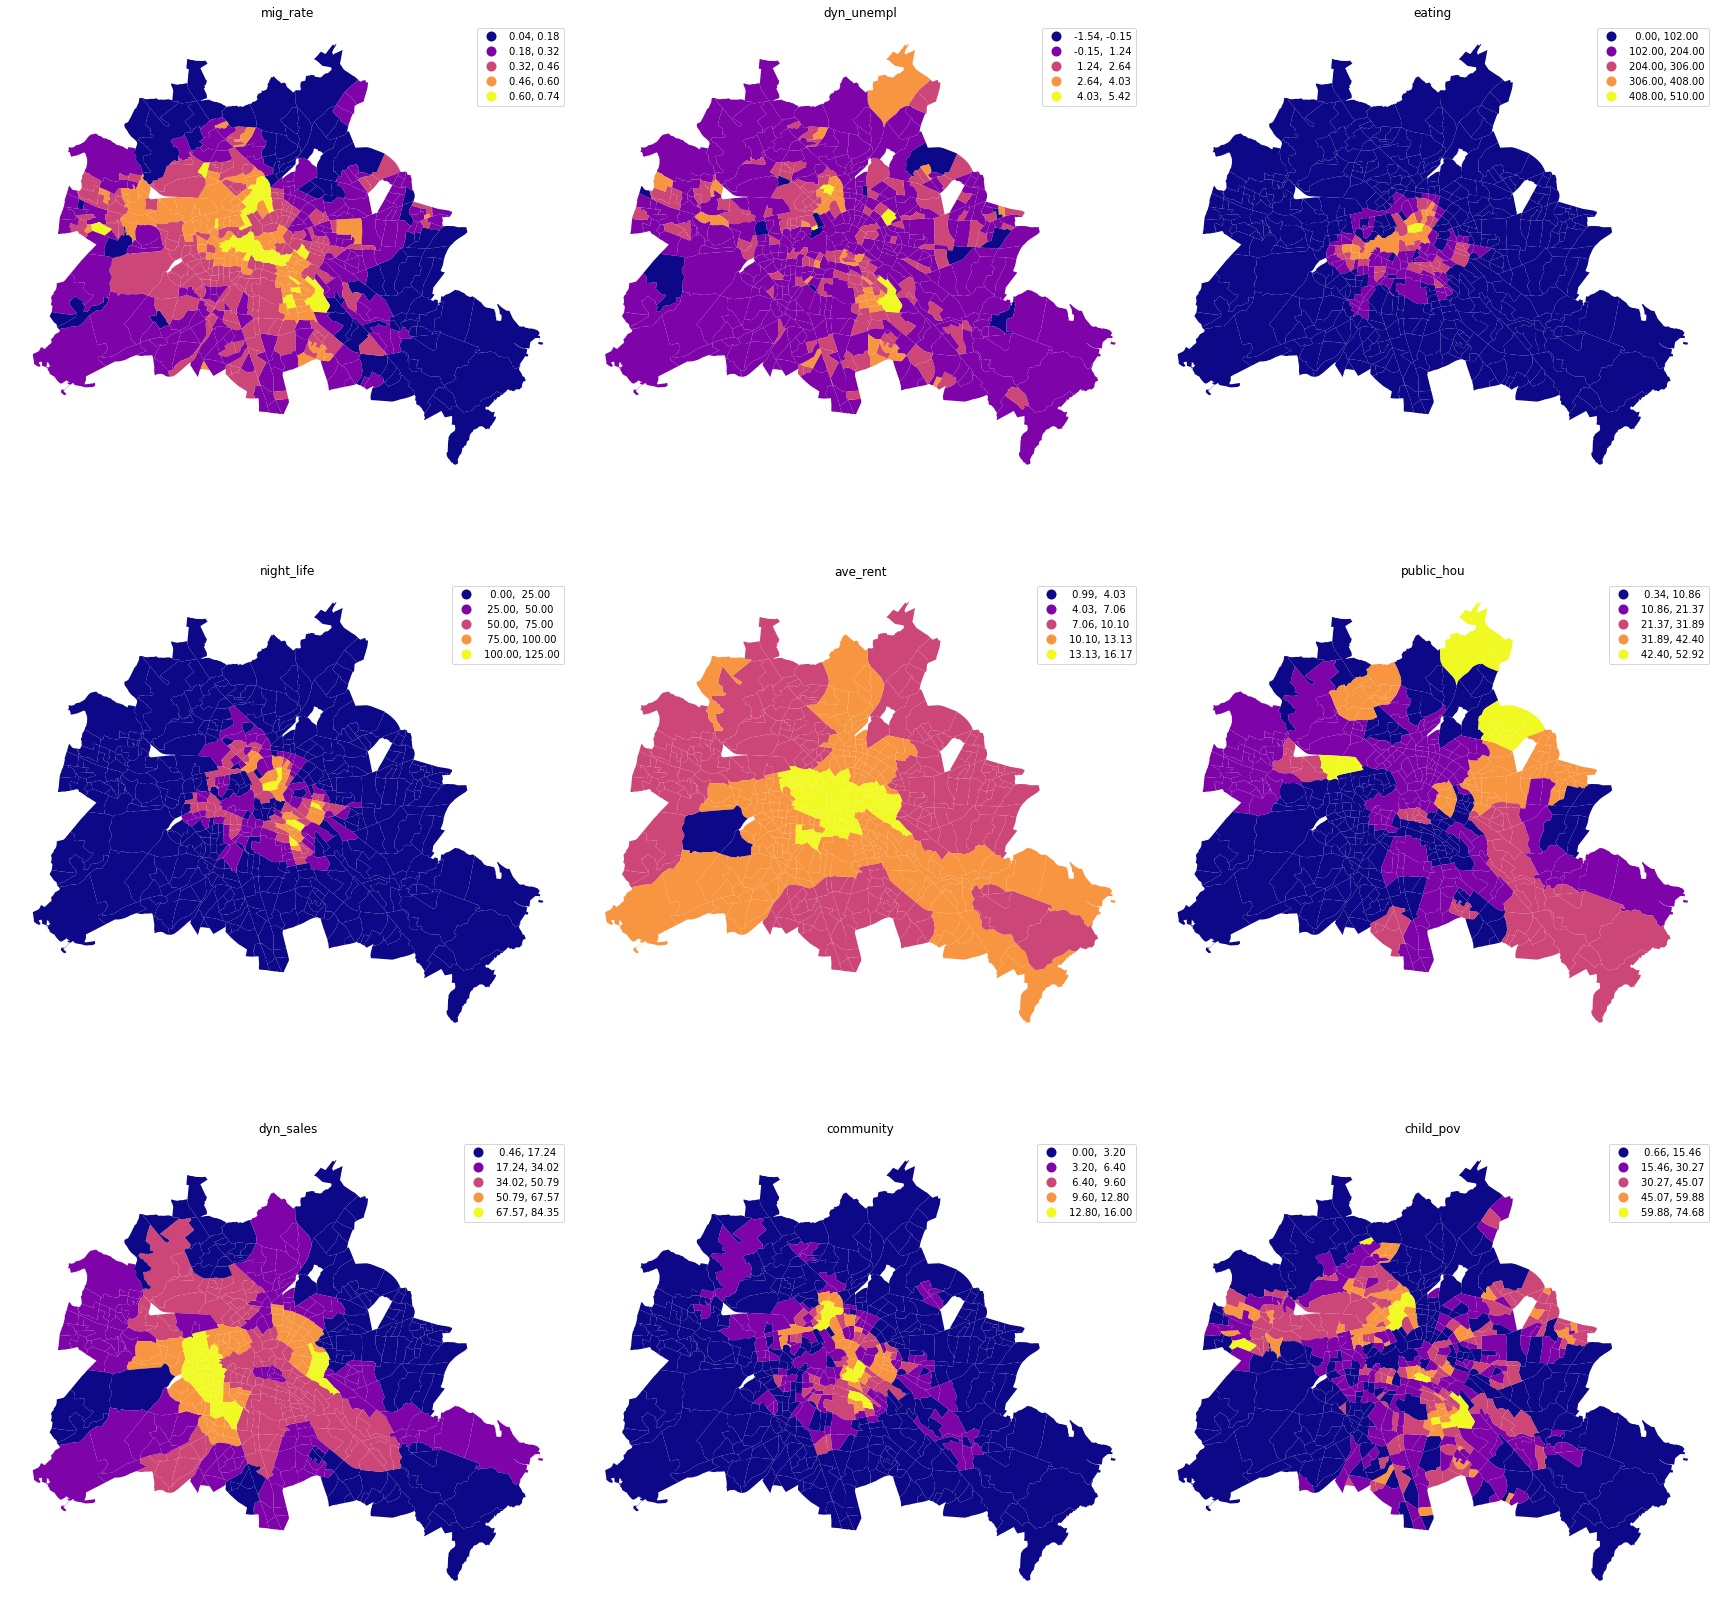

In [97]:
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(24, 24))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(iterable=clusters):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    selected.plot(
        column=col,
        ax=ax,
        scheme="EqualInterval",
        linewidth=0,
        cmap="plasma",
        legend=True
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
f.tight_layout()
plt.show()

In [34]:
queen = libpysal.weights.Queen.from_dataframe(selected)

In [98]:
from esda.moran import Moran

In [99]:
import seaborn

In [101]:
# Set seed for reproducibility
np.random.seed(123456)
# Calculate Moran's I for each variable
mi_results = [
    Moran(selected[variable], queen) for variable in clusters
]
# Structure results as a list of tuples
mi_results = [
    (variable, res.I, res.p_sim)
    for variable, res in zip(clusters, mi_results)
]
# Display on table
table = pd.DataFrame(
    mi_results, columns=["Variable", "Moran's I", "P-value"]
).set_index("Variable")
table

,Moran's I,P-value
Variable,,
mig_rate,0.733919,0.001
dyn_unempl,0.353758,0.001
eating,0.828862,0.001
night_life,0.817334,0.001
ave_rent,0.808404,0.001
public_hou,0.746134,0.001
dyn_sales,0.832748,0.001
community,0.748545,0.001
child_pov,0.519632,0.001


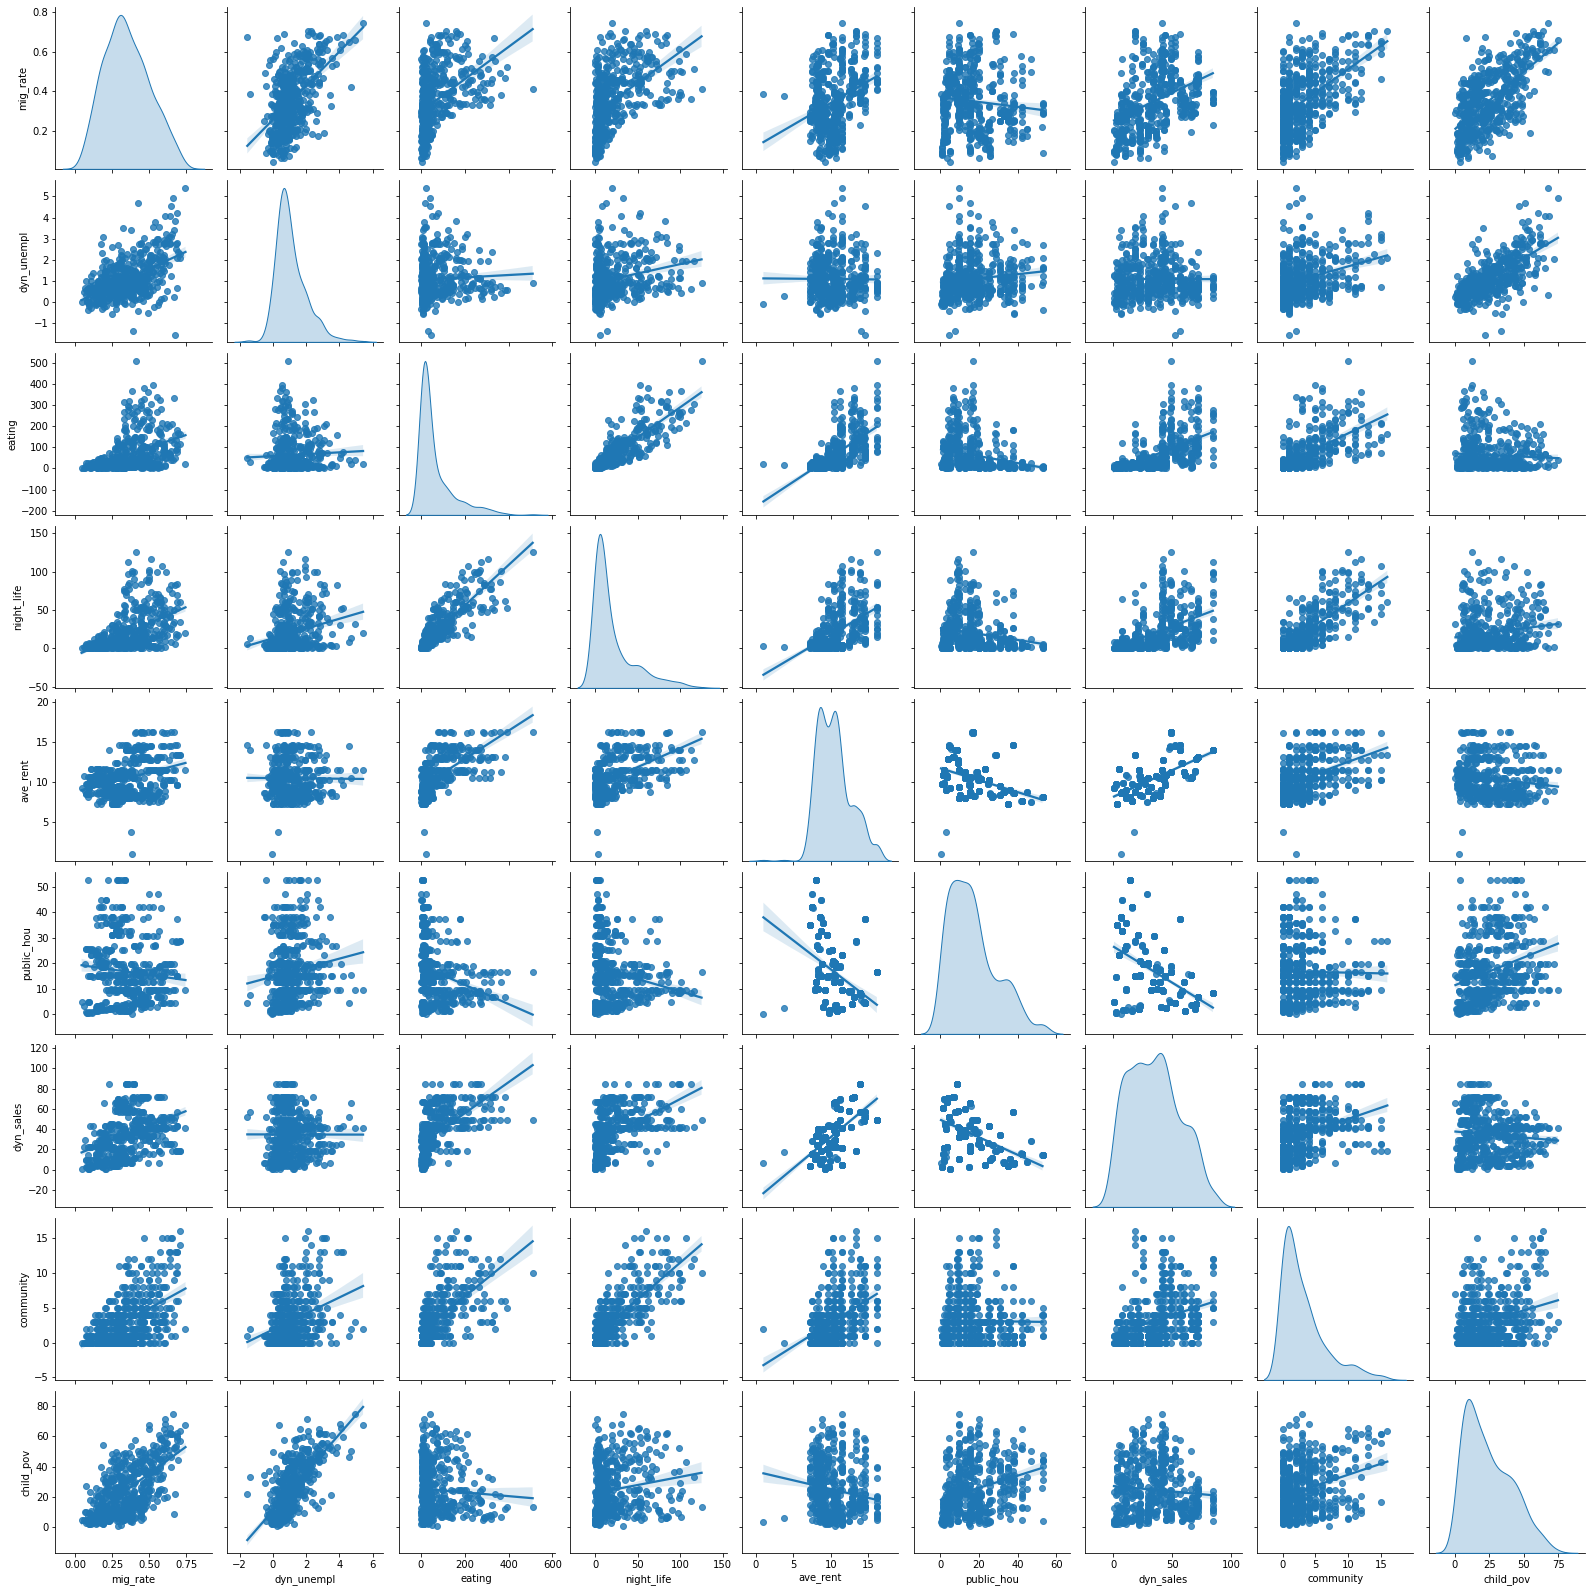

In [102]:
_ = seaborn.pairplot(
    selected[clusters], kind="reg", diag_kind="kde"
)

In [39]:
from sklearn.preprocessing import robust_scale

In [110]:
db_scaled = robust_scale(selected[clusters])

In [111]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
# Set the seed for reproducibility
np.random.seed(1234)
# Run K-Means algorithm
k5cls = kmeans.fit(db_scaled)
k5cls.labels_[:20]

array([2, 3, 0, 1, 0, 2, 0, 0, 2, 2, 2, 3, 2, 0, 3, 1, 2, 0, 2, 3],
      dtype=int32)

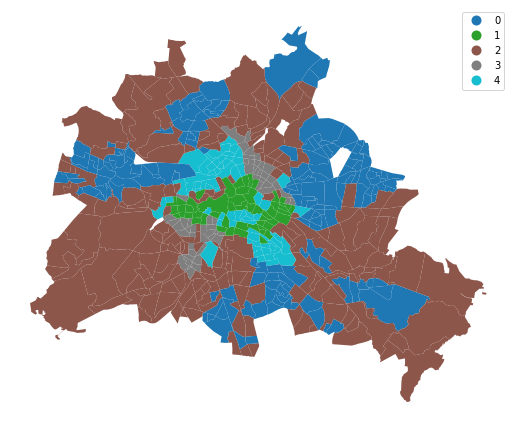

In [115]:
# Assign labels into a column
selected["k5cls"] = k5cls.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including
# a legend and with no boundary lines
selected.plot(
    column="k5cls", categorical=True, legend=True, linewidth=0, ax=ax
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

In [113]:
# Group table by cluster label, keep the variables used
# for clustering, and obtain their mean
k5means = selected.groupby("k5cls")[clusters].mean()
# Transpose the table and print it rounding each value
# to three decimals
k5means.T.round(3)

k5cls,0,1,2,3,4
mig_rate,0.332,0.466,0.257,0.352,0.570
dyn_unempl,1.345,0.917,0.525,0.840,2.474
eating,15.241,243.942,26.665,131.673,93.299
night_life,6.698,68.038,6.920,34.018,42.985
public_hou,29.035,11.937,10.842,10.799,13.502
ave_rent,8.450,13.847,10.319,11.772,11.777
education,0.160,1.654,0.330,4.618,1.254
dyn_sales,18.143,58.165,32.530,60.912,41.405
child_pov,33.810,19.381,13.552,14.007,47.581


In [114]:
# Group data table by cluster label and count observations
k5sizes = selected.groupby("k5cls").size()
k5sizes

k5cls
0    162
1     52
2    200
3     55
4     67
dtype: int64